

Code Reference:
The VGG16 architecture is refered from 
https://github.com/sahilsharma884/Music-Genre-Classification



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import librosa
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict
import itertools

np.random.seed(12345)


import keras
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input, Reshape
from keras.regularizers import l1
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, Input, Reshape
from keras.regularizers import l1
from sklearn.model_selection import train_test_split
from keras import utils
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import pickle

In [3]:
label = 0
genre = '/content/drive/MyDrive/Data3/genres_original'
genrelabel = {}

for folder in os.listdir(genre):
    if folder =='.DS_Store':
      continue
    genrelabel[folder] = label
    label = label+1

In [ ]:
genrelabel

{'classical': 0,
 'country': 1,
 'reggae': 2,
 'metal': 3,
 'disco': 4,
 'hiphop': 5,
 'jazz': 6,
 'blues': 7,
 'pop': 8,
 'rock': 9}

In [5]:
rate = 660000
X = []
y = []

for folder in os.listdir(genre):
    if folder =='.DS_Store':
      continue
    for files in tqdm.tqdm(os.listdir(genre+'/'+folder)):
        data, sr = librosa.load(genre+'/'+folder+'/'+files)
        data = data[:rate]
        X.append(data)
        y.append(genrelabel[folder])


100%|██████████| 100/100 [00:05<00:00, 19.55it/s]


In [6]:
def segment_generation(X,y,window_size = 0.1, overlap = 0.5):
    segment_X = []
    segment_y = []
    
    number_of_samples = X.shape[0]
    
    number_of_windows = int(number_of_samples * window_size)
    
    number_of_overlaps = int(number_of_windows * overlap)
    
    i = number_of_samples-number_of_windows + number_of_overlaps
    
    for j in range(0, i, number_of_overlaps):
        segment_X.append(X[j:j + number_of_windows])
        segment_y.append(y)
        
    return np.array(segment_X), np.array(segment_y)



In [7]:
X = np.array(X) 
y = np.array(y) 

main_segment_X = []
main_segment_y = []

for j in tqdm.tqdm(range(X.shape[0])):
    datax,datay = segment_generation(X[j], y[j])
    main_segment_X.append(datax)
    main_segment_y.append(datay)



100%|██████████| 999/999 [00:02<00:00, 339.54it/s]


In [8]:
#Feature extraction

def feature_stft(X):
    S = lambda x: librosa.stft(x, n_fft=1024, hop_length=512)[:,:,np.newaxis]
    feature = map(S,X)
    return np.array(np.abs(list(feature)))


In [9]:

X = np.array(main_segment_X)  
y = np.array(main_segment_y) 

features_X = []
features_y = []

for j in tqdm.tqdm(range(0,X.shape[0])):
    features_X.extend(feature_stft(X[j]))
    features_y.extend(y[j])



100%|██████████| 999/999 [00:46<00:00, 21.59it/s]


In [10]:
import tensorflow as tf
#Now lets split the data into train, validation and test

X = np.array(features_X) 
y = np.array(features_y) 

y = utils.np_utils.to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size = 0.2, stratify = y)
X_train, X_val, y_train,y_val = train_test_split(X_train,y_train, random_state=42, test_size = 0.1, stratify = y_train)


#Reshaping the data so that we can fit it to our deep learning models

X_train = np.squeeze(np.stack((X_train,) * 3, -1))
X_test = np.squeeze(np.stack((X_test,) * 3, -1))
X_val = np.squeeze(np.stack((X_val,) * 3, -1))


number_of_genres = 10
input_shape = X_train[0].shape
freezed_layers = 5

input_tensor = Input(shape = input_shape)

W = VGG16(include_top = False, weights = None, input_tensor=input_tensor)
top = Sequential()
top.add(Flatten(input_shape = W.output_shape[1:]))
top.add(Dense(32,activation='relu'))
top.add(Dense(number_of_genres,activation='softmax'))

model = Model(inputs=W.input,outputs=top(W.output))

for layer in model.layers[:freezed_layers]:
    layer.trainable = False
    
model.summary()
model.compile(loss=keras.losses.categorical_crossentropy,optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])

histogram = model.fit(X_train,y_train,batch_size=64,epochs=10,validation_data=(X_val,y_val))

with open('VGG16.pickle','wb') as f:
    pickle.dump(histogram.history, f)
    
model.save('VGG16.h5')

score = model.evaluate(X_test,y_test,verbose = 0)
print("Test_loss = {:.3f}, Test_accuracy = {:.3f}".format(score[0],score[1]))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 513, 129, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 513, 129, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 513, 129, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 256, 64, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 256, 64, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 256, 64, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 128, 32, 128)      0     

In [12]:
history_dict = histogram.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


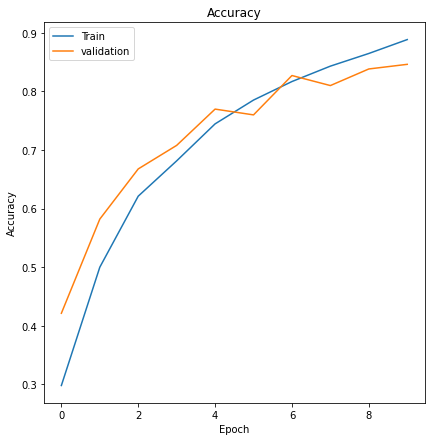

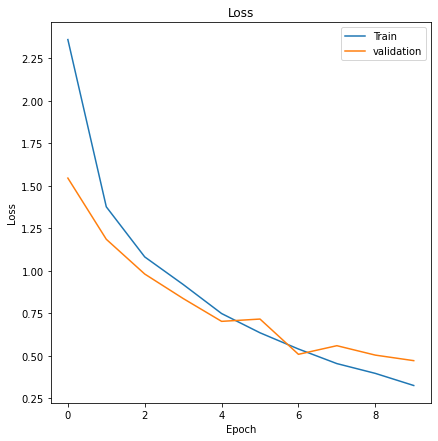

In [28]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(histogram.history['accuracy'], label='Train')
plt.plot(histogram.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(histogram.history['loss'], label='Train')
plt.plot(histogram.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

119/119 [==============================] - 149s 1s/step
(3797,)
(3797,)
[[331   0   0   0   2   0   5   0   3   3]
 [  5 256   4   1   2   0  11   7  11  29]
 [  1   8 291   0   2   4   3   3   4   8]
 [  0   0   0 349   4   3   0   1   0  34]
 [  2   6   7   3 338   1   7   6  14   7]
 [  0   0  34   2  11 358   0   8   8   2]
 [ 37  33   1   0   0   1 324   9   4   9]
 [  0  22   2   9   2   3  20 337   0  16]
 [  0   7  28   0  13   6   0   0 324   3]
 [  4  48  13  16   6   4   7   9  12 269]]
Normalized confusion matrix


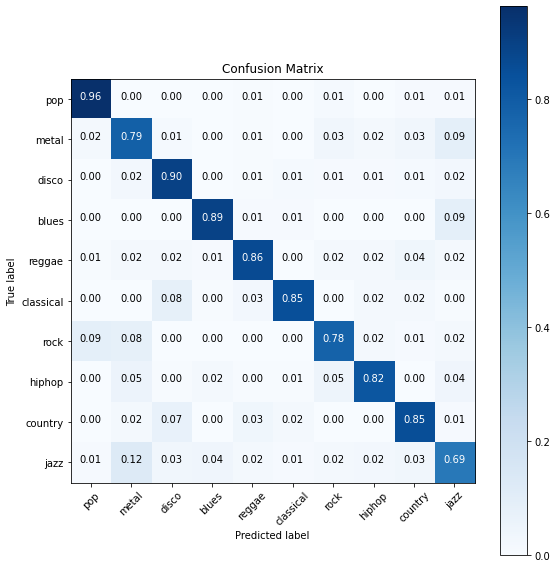

In [45]:
#Now let's plot the results
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm,keys, cmap=plt.cm.Blues, normalize=True, title='Confusion Matrix'):
  print(cm)
  if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
  else:
        print('Confusion matrix, without normalization')
  
  
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title('Confusion Matrix')
  plt.colorbar()
  tick_marks = np.arange(len(keys))
  plt.xticks(tick_marks, keys, rotation=45)
  plt.yticks(tick_marks, keys)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')




predicted = np.argmax(model.predict(X_test), axis=1)
true = np.argmax(y_test, axis=1)
print(true.shape)
print(predicted.shape)
cm = confusion_matrix(predicted, true)


genres = {'pop': 0,
 'metal': 1,
 'disco': 2,
 'blues': 3,
 'reggae': 4,
 'classical': 5,
 'rock': 6,
 'hiphop': 7,
 'country': 8,
 'jazz': 9}

keys=OrderedDict(sorted(genres.items(),key=lambda t:t[1])).keys()
#print(keys.shape)

plt.figure(figsize=(8,8))
plot_confusion_matrix(cm,keys,normalize=True)
plt.show()

Reference:
The VGG16 architecture is refered from 
https://github.com/sahilsharma884/Music-Genre-Classification